#### Bispectrum examples, using a wrapper around the PolyBin3D code developed by Oliver Philcox & Thomas Flöss (https://github.com/oliverphilcox/PolyBin3D)

In [1]:
from pathlib import Path
from acm.estimators import BasePolyBinEstimator, Bispectrum
from pypower import CatalogMesh
from acm.utils import setup_logging
from pypower import mpi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

setup_logging()

# read some random galaxy catalog
data_dir = '/pscratch/sd/e/epaillas/emc/hods/z0.5/yuan23_prior2/c000_ph000/'
data_fn = Path(data_dir) / 'hod3177.npy'
data = np.load(data_fn, allow_pickle=True).item()
boxsize = 2000.0
x = data['x']
y = data['y']
z_rsd = data['z_rsd']
data_positions = np.c_[x, y, z_rsd]

In [2]:
mesh = CatalogMesh(data_positions, boxsize=boxsize, nmesh=128,
                    boxcenter=0, wrap=True, position_type='pos', interlacing=0).to_mesh()
delta_mesh = mesh / np.mean(mesh) - 1

# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.10,0.02)
k_edges_squeeze = np.arange(0.01,0.15,0.02) # add extra high-k bins for squeezed triangles
lmax = 2

# load the base PolyBin class
base = BasePolyBinEstimator(boxsize=boxsize, boxcenter=[0, 0, 0],
                            gridsize=128, sightline='global', nthreads=256)

[000018.32]  04-13 17:03  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 3997577.
[000019.42]  04-13 17:03  CatalogMesh                  INFO     Painted 3997577 out of 3997577 objects to mesh.

# Dimensions: [2.00e+03, 2.00e+03, 2.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.003, 0.003, 0.003] h/Mpc
# Nyquist frequency: [0.201, 0.201, 0.201] h/Mpc
# Pixel window: none
# Using fftw backend


In [3]:
# Load the bispectrum class
bs = Bispectrum(base, 
                k_edges, # one-dimensional bin edges
                applySinv = None, # weighting function [only needed for unwindowed estimators]
                mask = None, # real-space mask
                lmax = lmax, # maximum Legendre multipole
                k_bins_squeeze = k_edges_squeeze, # squeezed bins
                include_partial_triangles = False, # whether to include bins whose centers do not satisfy triangle conditions
                )

# calculate the bispectrum
bk = bs.Bk_ideal(delta_mesh, discreteness_correction=False)


Binning: 4 bins in [0.010, 0.090] h/Mpc
Squezed binning: 6 bins in [0.010, 0.130] h/Mpc
l-max: 2
N_bins: 78
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
[000032.54]  04-13 17:03  Bispectrum                   INFO     Bispectrum calculated in 0.93 seconds.


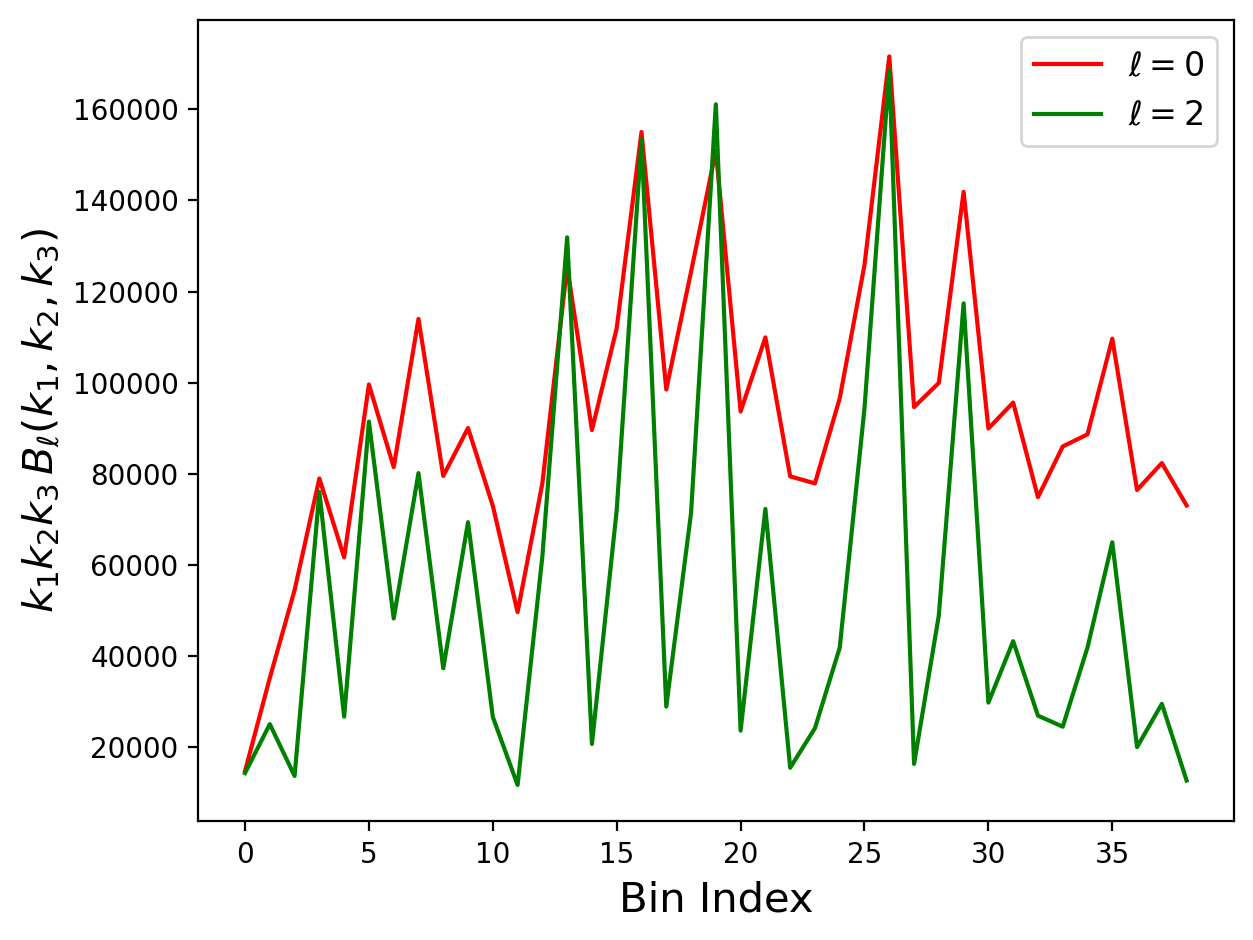

In [4]:
k123 = bs.get_ks()
cs = ['r','g']
weight = k123.prod(axis=0)
fig, ax = plt.subplots()
for l in range(0,lmax+1,2):
    ax.plot(weight*bk['b%d'%l],c=cs[l//2], ls='-', label=r'$\ell=%d$'%l)
ax.set_xlabel(r'Bin Index',fontsize=15)
ax.set_ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()